In [1]:
import numpy as np
import cygnus_lib as cy
import matplotlib.pyplot as plt
import mylib as my
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
%matplotlib inline
x_resolution = y_resolution = 2048
from itertools import combinations
pixelscale  = 0.125 #55e-3 #Orange 0.125 for lemonn mm/pixel

In [4]:

nsigma      = 1
run         = 833
traccia     = 0 #3
cimax       = 130
cimin       = 95# 85
dataSelection = 'LAB'
image = cy.swift_read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, run, traccia))
try:
    fileoutm = ("./data/run%d_mean.h5" % (run))
    m_image = cy.read_image_h5(fileoutm)
    PedOverMax = m_image[m_image > cimax].size
    print ("Pedestal mean: %.2f, sigma: %.2f, over th. (%d) %d" % 
       (m_image[m_image<cimax].mean(), 
        np.sqrt(m_image[m_image<cimax].var()), cimax,
        (m_image>cimax).sum()))
except:
    print ("No Pedestal file for run %s, run script runs-pedestals.ipynb" % run)
    print ("STOP")

try: 
    fileouts = ("./data/run%d_sigma.h5" % (run))
    s_image = cy.read_image_h5(fileouts)
    print ("Sigma mean: %.2f, sigma: %.2f, over th. (50) %d" % 
   (s_image[s_image<50].mean(), 
    np.sqrt(s_image[s_image<50].var()), 
    (s_image>50).sum()))
except:
    print ("No Sigma file for run %s, run script runs-pedestals.ipynb" % run)
    print ("STOP")

th_image    = np.round(m_image + nsigma*s_image)

Pedestal mean: 98.76, sigma: 1.07, over th. (130) 204
Sigma mean: 2.54, sigma: 2.12, over th. (50) 11


In [11]:
###### avarege NumImage
NumImage = 50 
max_image=np.size(cy.swift_listdir(cy.file2FullPathCygnus(dataSelection, run, 'H5')))
print ("# of Image Files: %d" % (max_image))
for iImg in range(0, NumImage):
    image += cy.swift_read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, run, iImg))
    print (">>> Image: %d" % (iImg))
image=image/NumImage
print(image.mean(), image.std())

# of Image Files: 100
>>> Image: 0
>>> Image: 1
>>> Image: 2
>>> Image: 3
>>> Image: 4
>>> Image: 5
>>> Image: 6
>>> Image: 7
>>> Image: 8
>>> Image: 9
>>> Image: 10
>>> Image: 11
>>> Image: 12
>>> Image: 13
>>> Image: 14
>>> Image: 15
>>> Image: 16
>>> Image: 17
>>> Image: 18
>>> Image: 19
>>> Image: 20
>>> Image: 21
>>> Image: 22
>>> Image: 23
>>> Image: 24
>>> Image: 25
>>> Image: 26
>>> Image: 27
>>> Image: 28
>>> Image: 29
>>> Image: 30
>>> Image: 31
>>> Image: 32
>>> Image: 33
>>> Image: 34
>>> Image: 35
>>> Image: 36
>>> Image: 37
>>> Image: 38
>>> Image: 39
>>> Image: 40
>>> Image: 41
>>> Image: 42
>>> Image: 43
>>> Image: 44
>>> Image: 45
>>> Image: 46
>>> Image: 47
>>> Image: 48
>>> Image: 49
122.68106762552262 25.33033924188057


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


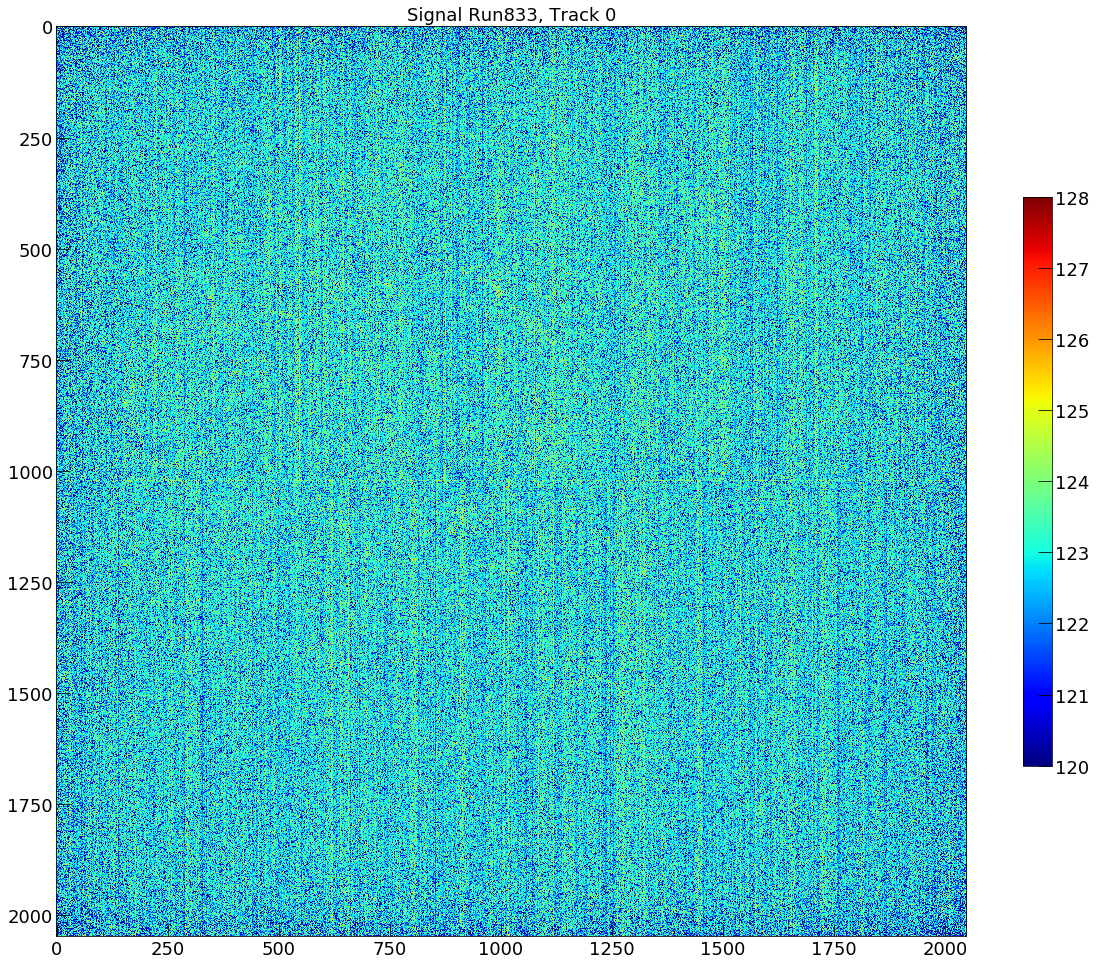

In [21]:
cy.set_atlas_style("large")
cimax       = 128
cimin       = 120
plt.imshow(image, vmin=cimin,vmax=cimax, cmap='jet')
plt.colorbar(shrink=0.5)
plt.title("Signal Run%d, Track %d" % (run, traccia))
plt.show()

# Attenzione i termini NEGATVE negative sono da usare per i settori della GEM

-6.0


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


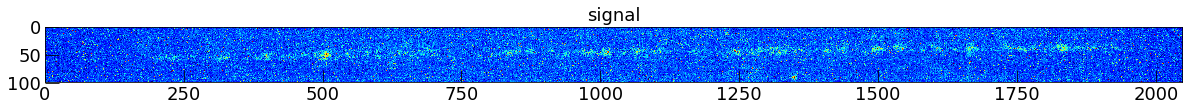

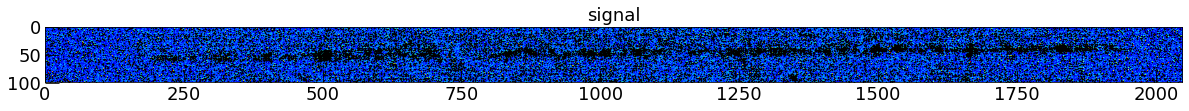

(array([  44.51804839, 1112.05553352]), array([-0.01057326,  0.9999441 ]))


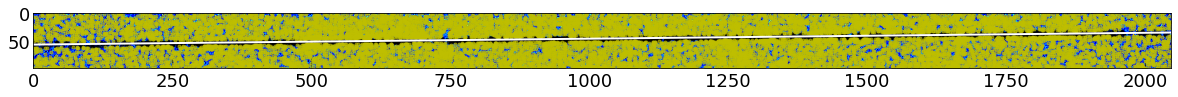

[752941.21463722   8039.47017347 752927.31301169]


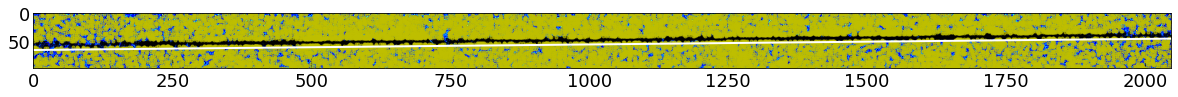

In [402]:
cy.set_atlas_style("large")
# run 55 NEGATIVE
#[330,430, 350,1750] 
#[600,700, 100,2048]
#[870,950, 100,2048]
#[1150,1230, 100,2048]
#[1400,1500, 350,1750]
##### ottimizzato per finetre verticali di 10 pixel
[ys,ye,xs,xe] = [980,1080, 0,2048] #run 87 traccia 5

#[ys,ye,xs,xe] = [1420,1520, 0,2048] #run 84 traccia 2
imageCutted = image[ys:ye,xs:xe]
trPos = 1024-(ys+ye)/2
print (trPos)
plt.imshow(imageCutted, vmin=cimin,vmax=cimax, cmap='jet')
#plt.colorbar(shrink=0.1)
plt.title("signal")
plt.show()
edges     = (imageCutted > 105) # NEGATVE per settori imageCutted < 108
# edges     = (imageCutted > 108) # NEGATVE 
plt.imshow(imageCutted, vmin=cimin,vmax=cimax, cmap='jet')
points    = np.array(np.nonzero(edges)).T.astype(float)
plt.plot(points[:,1], points[:,0], "k.", markersize=1)
#plt.colorbar(shrink=0.1)
plt.title("signal")
plt.show()
from skimage.measure import LineModelND, CircleModel, ransac

model = LineModelND()
model.estimate(points)

# robustly fit line only using inlier data with RANSAC algorithm
model_robust, inliers = ransac(points, LineModelND, min_samples=2,
                               residual_threshold=5, max_trials=1000)
outliers = inliers == False


line_x = np.arange(0, imageCutted.shape[1])
line_y = model.predict_y(line_x)
line_y_robust = model_robust.predict_y(line_x)
q,m = model_robust.params
print(model_robust.params)

fig, ax = plt.subplots()
plt.imshow(imageCutted, vmin=cimin,vmax=cimax, cmap='jet')
ax.plot(points[inliers, 1], points[inliers, 0], '.k', alpha=0.6,
        label='Inlier data', markersize=6)
ax.plot(points[outliers, 1], points[outliers, 0], '.y', alpha=0.6,
        label='Outlier data', markersize=6)
#ax.plot(line_y, line_x, '-y', label='Line model from all data')
ax.plot(line_y_robust, line_x, '-w', label='line fit', linewidth=2)
#ax.legend()
plt.xlim(0,imageCutted.shape[1]-1)
plt.ylim(imageCutted.shape[0]-1,0)
plt.show()

modelc = CircleModel()
modelc.estimate(points)

model_robustc, inliers = ransac(points, CircleModel, min_samples=3,
                               residual_threshold=5, max_trials=1000)

outliers = inliers == False
circle_t = np.linspace(0, 2 * np.pi, int(200 * np.pi))
circle_xy = modelc.predict_xy(circle_t)
circle_xy_robust = model_robustc.predict_xy(circle_t)

print(model_robustc.params)
ccy, ccx, ccr = model_robustc.params


fig, ax = plt.subplots()
plt.imshow(imageCutted, vmin=cimin,vmax=cimax, cmap='jet')
ax.plot(points[inliers, 1], points[inliers, 0], '.k', alpha=0.6,
        label='Inlier data', markersize=6)
ax.plot(points[outliers, 1], points[outliers, 0], '.y', alpha=0.6,
        label='Outlier data', markersize=6)
#ax.plot(line_y, line_x, '-y', label='Line model from all data')
ax.plot(circle_xy_robust[:,1], circle_xy_robust[:,0], '-w', label='circle fit', linewidth=2)
plt.xlim(0,imageCutted.shape[1]-1)
plt.ylim(imageCutted.shape[0]-1,0)
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


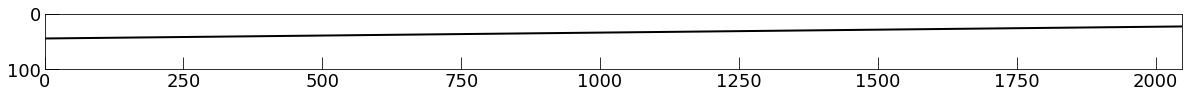

Differnce Mean: -1505801.91, max: 1505821.81 -250970.30
Center (752941.21,8039.47), Radius 752927.31
Curvature: 1.33e-06


In [403]:
f, ax0 = plt.subplots()
line_x = np.arange(0, x_resolution)
vsize = 100
y_circle = ccy + np.sqrt(ccr**2-(line_x-ccx)**2) #warning usare +/- a seconda della concavità
y_line = m[0]*line_x+q[0]
diff = y_line - y_circle
ax0.plot(line_x, y_circle, '-r', label='circle')
ax0.plot(line_x, y_line, '-k', label='line', linewidth=2)
ax0.set_aspect('equal', 'box')
#circle = plt.Circle((ccy, ccx), radius=ccr, facecolor='none', linewidth=2)
#ax0.add_patch(circle);
ax0.set_xlim(0,x_resolution)
ax0.set_ylim(vsize,0)
plt.show()

print("Differnce Mean: %.2f, max: %.2f %.2f" % (diff.mean(), abs(diff).max(), abs(diff).max()/trPos))
print("Center (%.2f,%.2f), Radius %.2f" % (ccy, ccx, ccr))
print("Curvature: %.2e" % (1/ccr))

offsset: -21
offsset: -13
offsset: -16
979 1081
21 2027


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


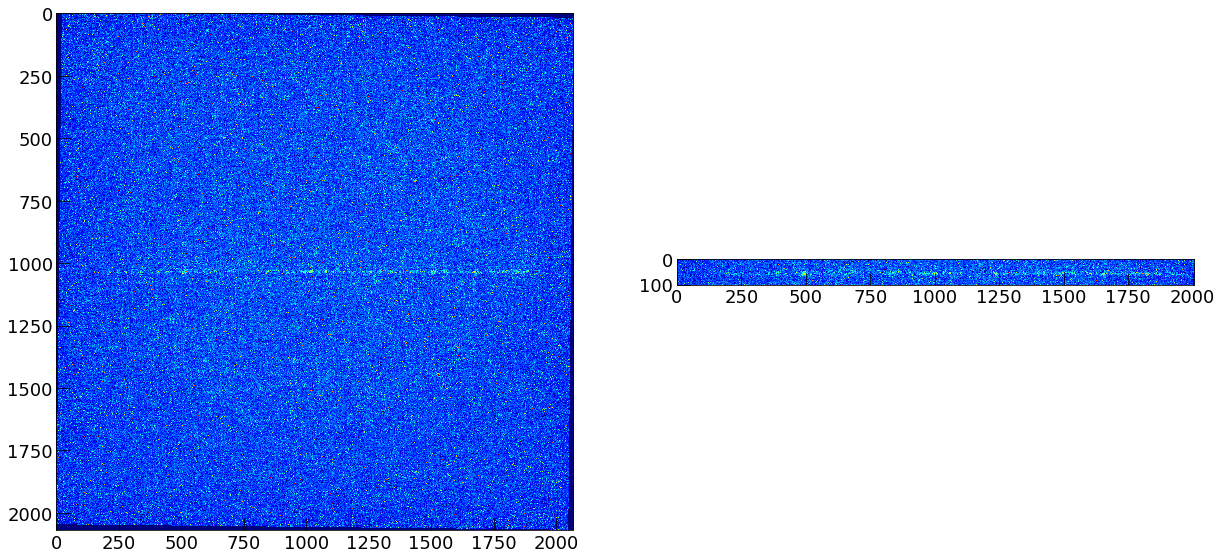

In [404]:
import scipy.ndimage
theta  = np.arctan(m[0])*(180.0/np.pi)
imgR   = scipy.ndimage.interpolation.rotate(image, theta)
m_imgR = scipy.ndimage.interpolation.rotate(m_image, theta)
s_imgR = scipy.ndimage.interpolation.rotate(s_image, theta)
print ("offsset: %d" % (x_resolution*m[0]))
print ("offsset: %d" % (1300*m[0]))
print ("offsset: %d" % (1600*m[0]))
fig, ax = plt.subplots(1,2)
ax[0].imshow(imgR, vmin=cimin,vmax=cimax, cmap='jet')
#[ys+(ye-ys)*m[0]:ye-(ye-ys)*m[0],xs+(xe-xs)*m[0]:xe-(xe-xs)*m[0]]
#ax[1].imshow(imgR[970:1070,200+int(1300*m[0]):2000+int(1490*m[0])], vmin=cimin,vmax=cimax, cmap='jet')
ax[1].imshow(imgR[(ys+int((ye-ys)*m[0])):
                  (ye-int((ye-ys)*m[0])),
                  (xs-int((xe-xs)*m[0])):
                  (xe+int((xe-xs)*m[0]))], 
             vmin=cimin,vmax=cimax, cmap='jet')
print(ys+int((ye-ys)*m[0]),ye-int((ye-ys)*m[0]))
print(xs-int((xe-xs)*m[0]),xe+int((xe-xs)*m[0]))
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


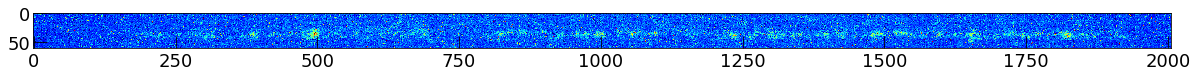

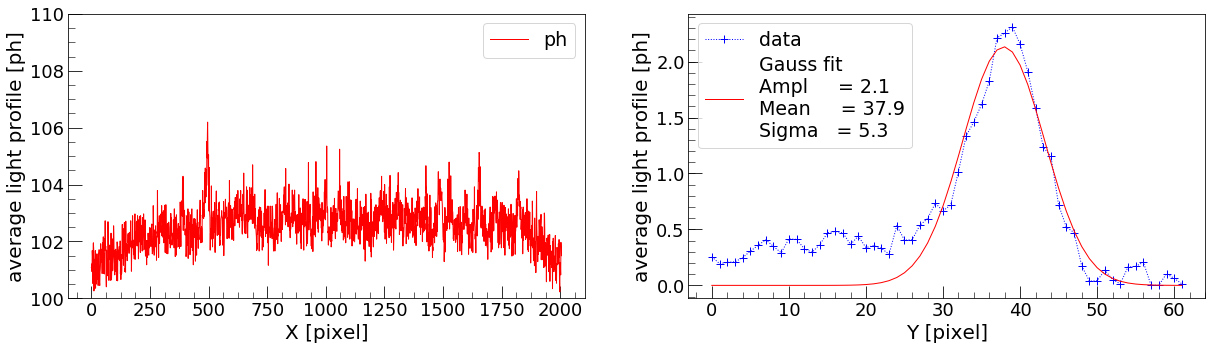

Int light in X: 205572.79 [ph*pixel]
Int light in Y: 6254.77 [ph*pixel]
Light, X: 12547070.00 / Y: 12745513.00 [ph]


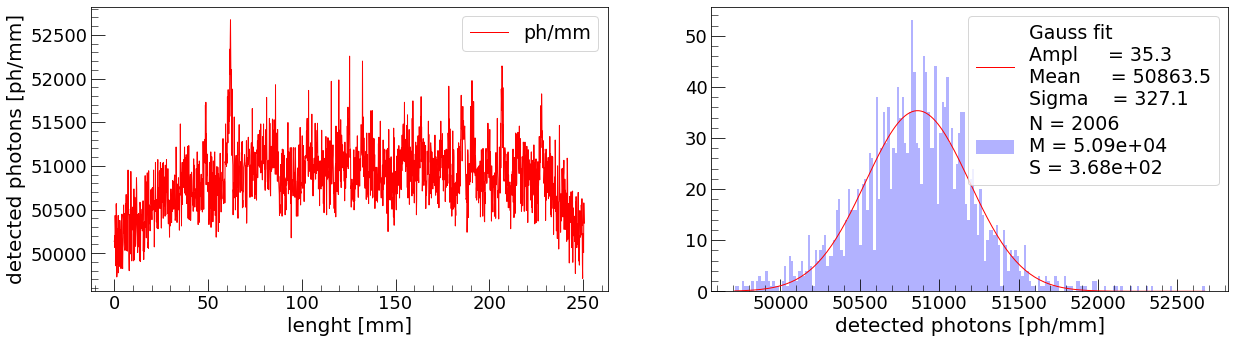

In [409]:

cy.set_atlas_style('long')
# 2 - [360:390, 350:1750]
# 1 - [630:670, 800:1900]
# 0 - [900:940, 100:2048]
#-1 - [1170:1210, 100:2048]
#-2 - [1445:1475, 350:1750]
#imageCutted = image[ys+30:ye-30,xs:xe]
imageCutted = imgR[abs(ys+int((ye-ys)*m[0]))+20:
                  abs(ye-int((ye-ys)*m[0]))-20,
                  abs(xs-int((xe-xs)*m[0])):
                  abs(xe+int((xe-xs)*m[0]))]
plt.imshow(imageCutted, vmin=cimin,vmax=cimax, cmap='jet')

plt.show()
fig, ax = plt.subplots(1,2)
#
Xproj       = np.mean(imageCutted, axis=0)
Yproj       = np.mean(imageCutted, axis=1)

xx          = np.arange(0, imageCutted.shape[1])
xy          = np.arange(0, imageCutted.shape[0])


#

ax[0].plot(xx, Xproj, 'r-', label='ph')
ax[0].set_ylabel('average light profile [ph]')
ax[0].set_xlabel('X [pixel]')
ax[0].minorticks_on()
ax[0].set_ylim(100,110)
ax[0].legend()

#######
Ymaen = Yproj.mean() # 
Ymin = Yproj.min() #
######
x0 = xy.size/2
s0 = 5
a0 = max(Yproj-Ymin) 
# a0 = max(Ymaen-Yproj) # NEGATIVE

ax[1].plot(xy, Yproj-Ymin, 'b+:', label='data') 
# ax[1].plot(xy, Ymaen-Yproj, 'b+:', label='data') # NEGATIVE
try:
    popt,pcov = curve_fit(my.Gauss3, xy, Yproj-Ymin, p0=[a0, x0, s0]) 
    # curve_fit(my.Gauss3, xy, Ymaen-Yproj, p0=[a0, x0, s0]) # NEGATIVE
    ax[1].plot(xy, my.Gauss3(xy, *popt), 'r-',
           label='Gauss fit   \nAmpl     = %.1f\nMean     = %.1f\nSigma   = %.1f' %
           (popt[0], popt[1], popt[2]))
    Afit = popt
except:
    print ("fit error")

ax[1].set_xlabel('Y [pixel]')
ax[1].set_ylabel('average light profile [ph]')
ax[1].minorticks_on()
ax[1].legend()
plt.show()


fig, ax = plt.subplots(1,2)
DDY = np.trapz(Yproj,xy)
DDX = np.trapz(Xproj,xx)
print("Int light in X: %.2f [ph*pixel]" % DDX)
print("Int light in Y: %.2f [ph*pixel]" % DDY)
print("Light, X: %.2f / Y: %.2f [ph]" % (DDY*xx.size, DDX*xy.size))


eres = Xproj*xy.size/pixelscale

ax[0].plot(xx*pixelscale, eres, 'r-', label='ph/mm')
ax[0].set_ylabel('detected photons [ph/mm]')
ax[0].set_xlabel('lenght [mm]')
ax[0].legend()
ax[0].minorticks_on()
bins = int(eres.size/10)
ax[1].hist(eres, bins=bins, color='blue', alpha=0.3, label='N = %d\nM = %.2e\nS = %.2e' % 
       (np.size(eres), np.mean(eres), np.sqrt(np.var(eres))))
x    = np.linspace(eres.min(), eres.max(), bins)
y, _ = np.histogram(eres, bins=bins)
a0 = np.max(y)
x0 = np.mean(eres)
s0 = np.sqrt(np.var(eres))
try:
    popt,pcov = curve_fit(my.Gauss3, x, y, p0=[a0, x0, s0])
    x = np.linspace(eres.min(), eres.max(), bins)
    ax[1].plot(x, my.Gauss3(x, *popt), 'r-',
           label='Gauss fit   \nAmpl     = %.1f\nMean     = %.1f\nSigma    = %.1f' %
           (popt[0], popt[1], popt[2]))
except:
    print("fit error")

ax[1].set_xlabel('detected photons [ph/mm]')
ax[1].minorticks_on()
#ax[1].set_xlim(32000,35000)
ax[1].legend()
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


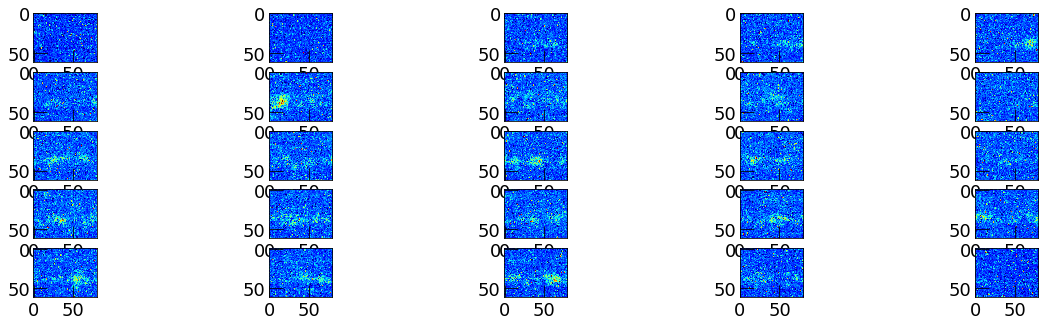

Unable to fit data...
Unable to fit data...


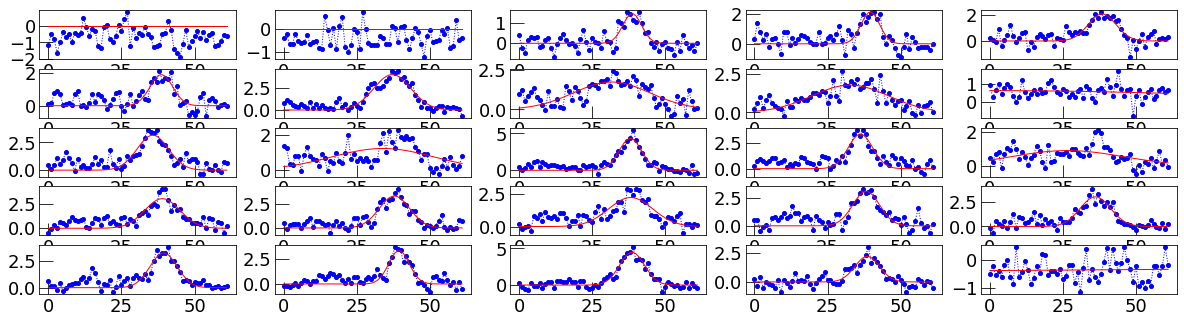

In [410]:
nslide    = 5
fitVar    = np.ndarray((nslide*nslide, 3), dtype=np.float64)
dy0 = imageCutted.shape[0]

slide     = np.int(imageCutted.shape[1]/(nslide*nslide))
f, axarr  = plt.subplots(nslide, nslide)
e_slide   = 0
xplot = np.arange(0, dy0)
for j in range(0, nslide):
    for k in range(0, nslide):
        s_slide = e_slide 
        e_slide = s_slide + slide
        axarr[j, k].imshow(imageCutted[0:,s_slide:e_slide], vmin=cimin,vmax=cimax, cmap='jet')

plt.show()
f, axarr  = plt.subplots(nslide, nslide)
e_slide   = 0

ji        = 0

for j in range(0, nslide):
    for k in range(0, nslide):
        s_slide = e_slide 
        e_slide = s_slide + slide
        y  = np.mean(imageCutted[0:,s_slide:e_slide]-Ymin, axis=1)
        # y  = np.mean(Ymaen-imageCutted[0:,s_slide:e_slide], axis=1) #NEGATIVE
        a0 = Afit[0]
        x0 = Afit[1]
        s0 = Afit[2]
        try:
            popt,pcov = curve_fit(my.Gauss3, xplot, y, p0=[a0, x0, s0])
            perr = np.sqrt(np.diag(pcov))
            fitVar[ji,] = popt
        except:
            print("Unable to fit data...")
            fitVar[ji,] = [a0, x0, s0]

        axarr[j, k].plot(xplot, y, 'b:.')
        axarr[j, k].plot(xplot, my.Gauss3(xplot, *popt), 'r-', label='A = %.2e\nS = %.2e' % (popt[0], popt[2]))
        #axarr[j, k].legend()
        fitVar[ji,] = popt
        ji+=1
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


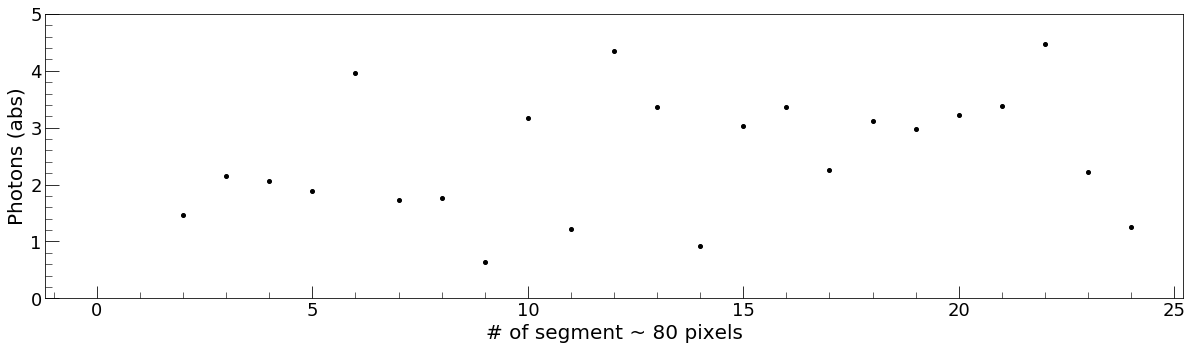

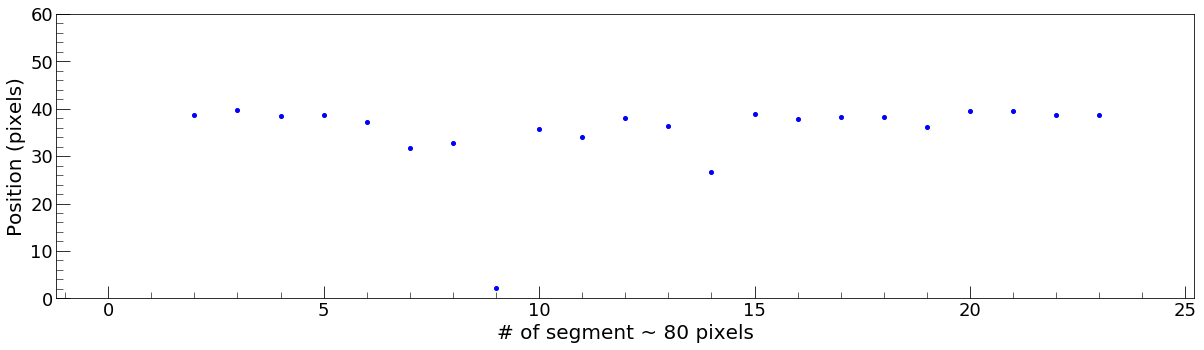

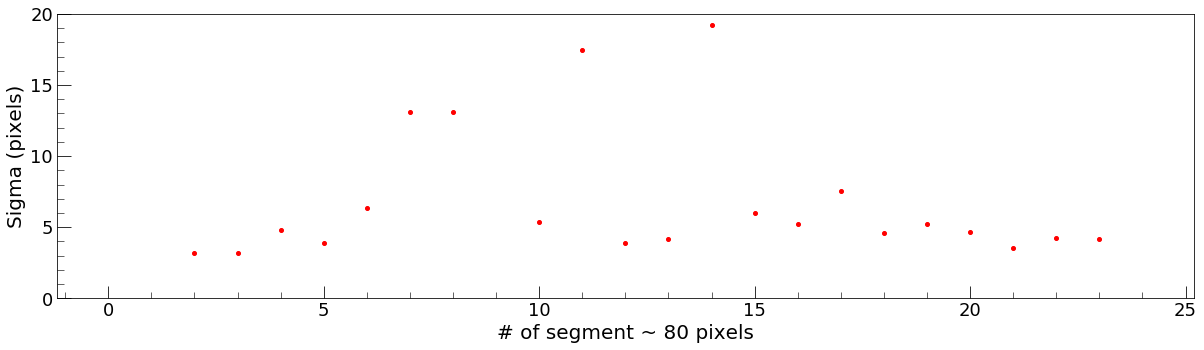

In [413]:
y = abs(fitVar[:,0])
x = np.arange(0, y.shape[0])
plt.plot(x, y, "k.")
plt.ylabel('Photons (abs)')
plt.xlabel('# of segment ~ %d pixels' % slide)
plt.ylim(0,5)
plt.minorticks_on()
plt.show()
y = abs(fitVar[:,1])
x = np.arange(0, y.shape[0]) 
plt.plot(x, y, "b.")
plt.ylabel('Position (pixels)')
plt.xlabel('# of segment ~ %d pixels' % slide)
plt.minorticks_on()
plt.ylim(0,60)
plt.show()
y = abs(fitVar[:,2])
x = np.arange(0, y.shape[0]) 
plt.plot(x, y, "r.")
plt.ylabel('Sigma (pixels)')
plt.xlabel('# of segment ~ %d pixels' % slide)
plt.minorticks_on()
plt.ylim(0,20)
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


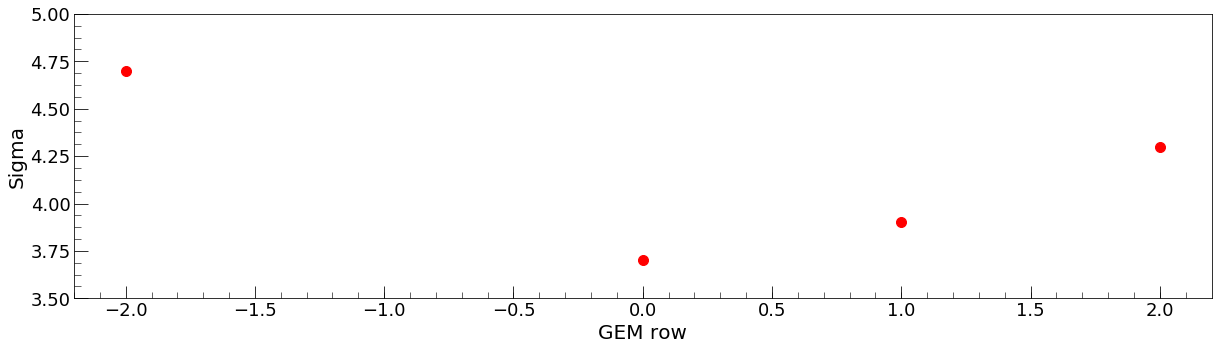

In [373]:
y = np.array([4.7,6.7,3.7,3.9,4.3])
x = np.arange(-2, y.shape[0]/2)
plt.plot(x, y, "r.", markersize=20)
plt.ylabel('Sigma')
plt.xlabel('GEM row')
plt.ylim(3.5,5)
plt.minorticks_on()
plt.show()